# AOI Demo Defect Detection Inference

In [1]:
# import sys
# print(f"Install in: {sys.executable}")
# !{sys.executable} -m pip install ipywidgets

In [2]:
from ast import literal_eval
from pathlib import Path
import os
import pickle
import random
import itertools
import datetime
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
from IPython import display
from IPython.core.display import HTML

import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

import torch
# common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.data.transforms import ResizeShortestEdge
from detectron2.checkpoint import DetectionCheckpointer
from detectron2.utils.visualizer import ColorMode
from detectron2.data.datasets import register_coco_instances, load_coco_json
from detectron2.data import DatasetMapper, build_detection_test_loader
from detectron2.modeling import build_model
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
from detectron2.structures import BoxMode

In [3]:
import sys
sys.path.insert(0, '../src')

from data.utils import xyxy_to_xywh, xywh_xyxy
from data.datasets import (
    register_custom_coco_instances,
    load_coco_json_with_attributes,
    get_meta_info
)
from visualization.visualize import plot_img_with_anns
from config import add_sub_head_config

# this adds the custom model to the ROI_HEADS_REGISTRY
from modeling.sub_roi_heads import StandardWithSubROIHeads

## Settings

In [4]:
# show all rows of a pandas table if necessar
pd.set_option('display.max_rows', None)

# Let Notebook have full width to make the image plots larger
display.display(HTML("<style>.container { width:100% !important; }</style>"))

## Config

In [7]:
log_path = Path(f"./logs/rcnn")
model_path = log_path / 'model_final.pth'
config_path = log_path / 'train_config.yaml'
is_subhead_model = False

In [8]:
cfg = get_cfg()
if is_subhead_model:
    add_sub_head_config(cfg)

cfg.merge_from_file(str(config_path))
cfg.MODEL.WEIGHTS = str(model_path)

if "retina" in str(log_path):
    cfg.MODEL.RETINANET.SCORE_THRESH_TEST = 0.5
else:
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5 # testing threshold

#print(cfg.dump())

## Data

In [9]:
data_path = Path("../../data/ES")
test_ann_path = data_path / 'test_instances_coco.json'
data_config_path = data_path / 'cvat_project_config.json'

if model_path.is_file():
    print(f'Using trained model {model_path}')
else:
    # Load default pretrained model from Model Zoo
    print(f'No model found at {model_path}')

Using trained model logs/rcnn/model_final.pth


In [10]:
if is_subhead_model:
    sub_class_list = ['subClass', 'defectClass']
    meta_dict = get_meta_info(test_ann_path, data_config_path, sub_class_list)        
    
    test_dicts = load_coco_json_with_attributes(test_ann_path, 
                                                data_path, 
                                                "aoi_test",
                                                meta_dict,
                                                sub_class_list)
    
    register_custom_coco_instances(
            "aoi_test", meta_dict, test_ann_path, data_path, sub_class_list)
    
else:
    test_dicts = load_coco_json(test_ann_path, data_path, dataset_name="aoi_test")
    
    register_coco_instances("aoi_test", {}, test_ann_path, data_path)
    
aoi_metadata = MetadataCatalog.get(f"aoi_test")

[09/23 16:14:07 d2.data.datasets.coco]: Loaded 76 images in COCO format from ../../data/ES/test_instances_coco.json


## Inference

Using official detectron2 inference approach

In [11]:
predictor = DefaultPredictor(cfg)

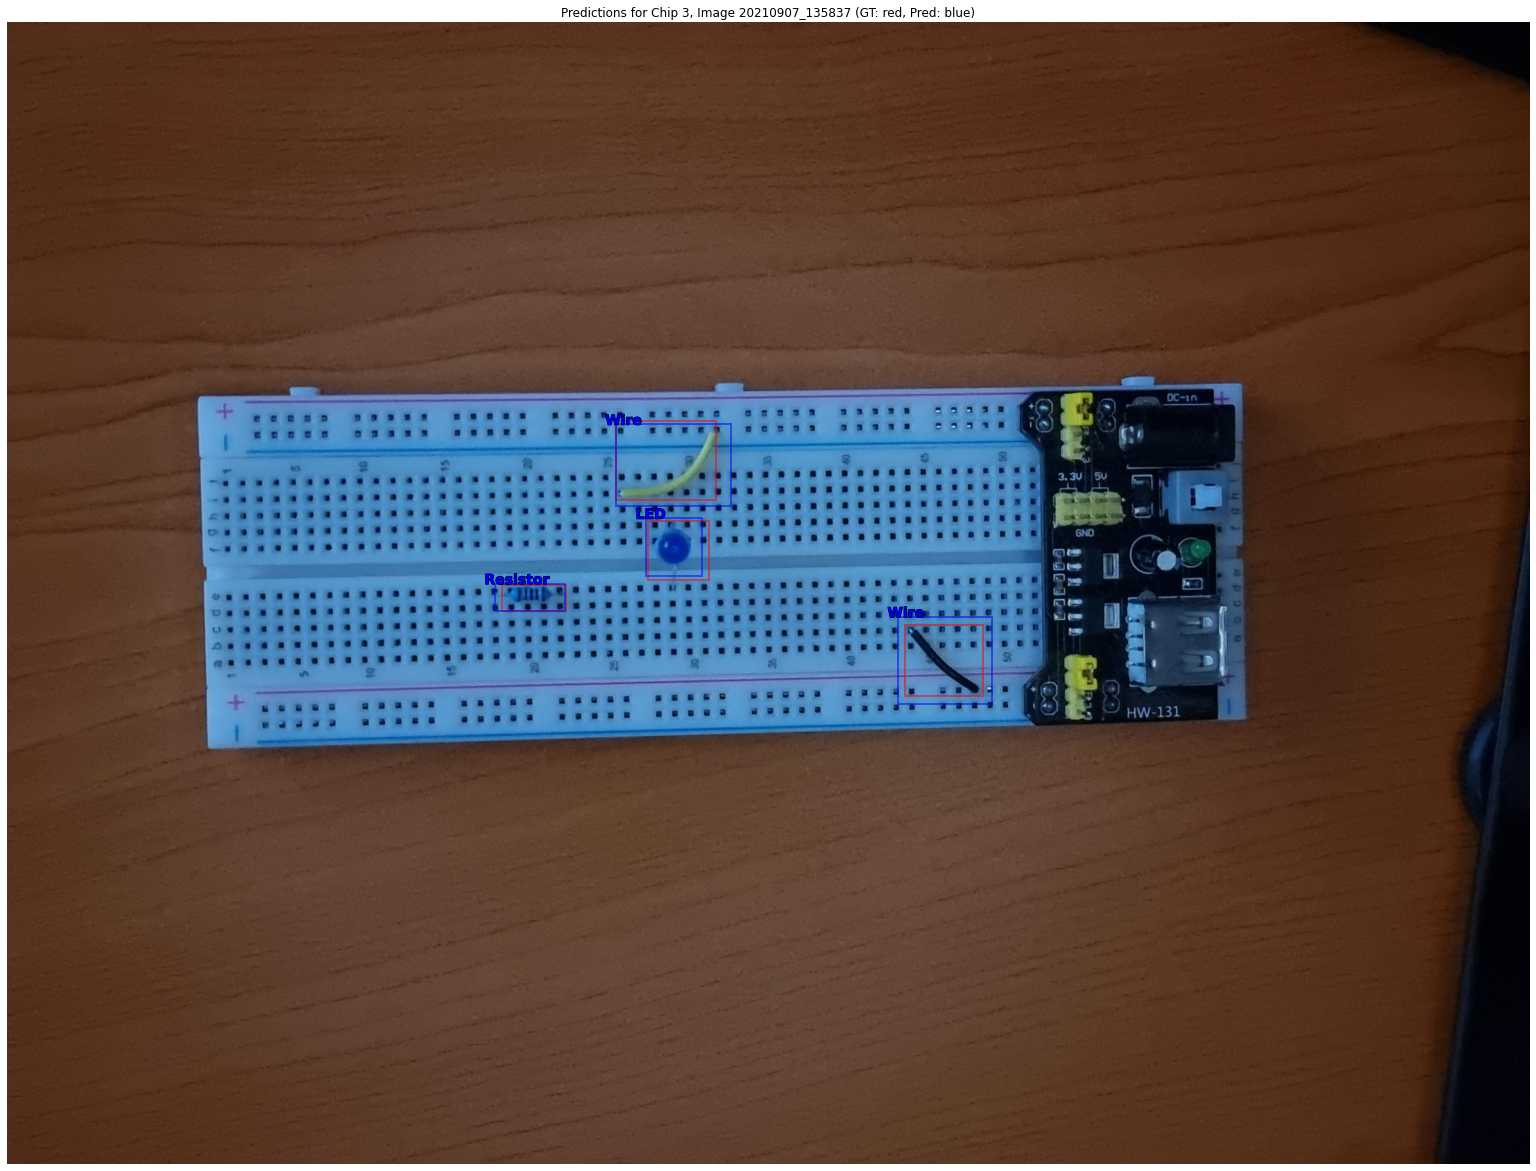

In [13]:
for d in random.sample(test_dicts, 1):    
    img_path = Path(d["file_name"])
    img_name = img_path.stem
    chip_name = img_path.parent.stem
    
    img = cv2.imread(d["file_name"])    
    outputs = predictor(img) 
    
    gt_anns = d['annotations']

    instances = outputs["instances"].to("cpu")

    pred_bboxes = instances.pred_boxes.tensor.numpy()
    pred_bboxes = BoxMode.convert(pred_bboxes, BoxMode.XYXY_ABS, BoxMode.XYWH_ABS)
    pred_classes = instances.pred_classes.numpy()
    
    pred_anns = []
    for bbox, cat_id in zip(pred_bboxes, pred_classes):
        pred_ann = {            
            'bbox' : list(bbox),
            'category_id' : cat_id,
            'bbox_mode' : BoxMode.XYWH_ABS,
            'category_name' : aoi_metadata.thing_classes[cat_id]
        }
        pred_anns.append(pred_ann)
            
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)    
    ax = plot_img_with_anns(img, gt_anns, pred_anns, figsize=(28, 21), title=f"Predictions for Chip {chip_name}, Image {img_name} (GT: red, Pred: blue)")    

## Inference with Sub Class predictions

Using official detectron2 inference approach

In [ ]:
assert is_subhead_model, "Subhead inference has to be activated to load the data correctly"
predictor = DefaultPredictor(cfg)

In [ ]:
for d in random.sample(test_dicts, 1):    
    img_path = Path(d["file_name"])
    img_name = img_path.stem
    chip_name = img_path.parent.stem
    
    img = cv2.imread(d["file_name"])    
    outputs = predictor(img) 
    
    gt_anns = d['annotations']

    instances = outputs["instances"].to("cpu")

    pred_bboxes = instances.pred_boxes.tensor.numpy()
    pred_bboxes = BoxMode.convert(pred_bboxes, BoxMode.XYXY_ABS, BoxMode.XYWH_ABS)
    pred_classes = instances.pred_classes.numpy()
    pred_sub_classes = instances.pred_sub_classes.numpy()
    
    pred_anns = []
    for bbox, cat_id, sub_id in zip(pred_bboxes, pred_classes, pred_sub_classes):
        if 'subClass_classes' in aoi_metadata.sub_classes[cat_id]:
            sub_name = aoi_metadata.sub_classes[cat_id]['subClass_classes'][sub_id]
        else:
            sub_name = "None"
        pred_ann = {            
            'bbox' : list(bbox),
            'category_id' : cat_id,
            'bbox_mode' : BoxMode.XYWH_ABS,
            'category_name' : aoi_metadata.thing_classes[cat_id],
            'sub_class_id' : sub_id,
            'sub_class_name' : sub_name
        }
        pred_anns.append(pred_ann)
            
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)    
    ax = plot_img_with_anns(img, gt_anns, pred_anns, figsize=(20, 15), title=f"Predictions for Chip {chip_name}, Image {img_name} (GT: red, Pred: blue)")    

In [ ]:
# Print List of all Elments
print("GT, Prediction")
for gt_ann, pred_ann in zip(gt_anns, pred_anns): 
    el_cat_id = gt_ann["category_id"]
    gt_el_name = aoi_metadata.thing_classes[el_cat_id]
    if 'subClass' in gt_ann['attributes']:           
        gt_sub_id = gt_ann['attributes']['subClass']
        gt_sub_name = aoi_metadata.sub_classes[el_cat_id]['subClass_classes'][gt_sub_id]
    else:
        gt_sub_name = "None"
    pred_cat_id = pred_ann["category_id"]
    pred_el_name = aoi_metadata.thing_classes[pred_cat_id]
    pred_sub_id = pred_ann['sub_class_id'] 
    if pred_sub_id == -1:
        pred_sub_name = "None"
    else:
        pred_sub_name = aoi_metadata.sub_classes[pred_cat_id]['subClass_classes'][pred_sub_id]

    print(f"{gt_el_name}: {gt_sub_name}", f"{pred_el_name}: {pred_sub_name}", sep='\t')

## Manual Inference

Using model stored in own format with as little dependencies as possible

In [ ]:
target_shape = (768, 1024) # width, height (because openCV)
model_pkl_path = model_path.parent / f"{model_path.stem}.pkl"

with open(model_pkl_path, "rb") as f:
    state_dict = pickle.load(f)
    model = state_dict["model"]
    input_format = state_dict["input_format"]
    thing_classes = state_dict["thing_classes"]
    
model.eval()

print(f"Model device: {next(model.parameters()).device}")

In [ ]:
img_path = data_path / "9" / "IMG_20210302_185523.jpg"
img = cv2.imread(str(img_path))

In [ ]:
# pre-processing
if input_format == "RGB":
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  
img = cv2.resize(img, target_shape, interpolation = cv2.INTER_AREA)
image = torch.as_tensor(img.astype("float32").transpose(2, 0, 1))

# inference
with torch.no_grad():
    inputs = {"image": image, "height": target_shape[1], "width": target_shape[0]}
    outputs = model([inputs])[0]

# post-processing
instances = outputs["instances"].to("cpu")

pred_bboxes = instances.pred_boxes.tensor.numpy()
pred_bboxes = map(xyxy_to_xywh, pred_bboxes)

pred_classes = instances.pred_classes.numpy()

pred_anns = []
for bbox, cat_id in zip(pred_bboxes, pred_classes):
    pred_ann = {            
        'bbox' : list(bbox),
        'category_id' : cat_id,
        'bbox_mode' : 'XYWH_ABS',
        'category_name' : thing_classes[cat_id]
    }
    pred_anns.append(pred_ann)

# Plot
img_name = img_path.stem
chip_name = img_path.parent.stem
ax = plot_img_with_anns(img, None, pred_anns, figsize=(28, 21), title=f"Predictions for Chip {chip_name}, Image {img_name}") 